In [7]:
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep")

In [11]:
def sim_clock(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True) for _c in c]
    return c, hr_clock

def sim_ran_clock_rp(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, rp=True) for _c in c]
    return c, hr_ran_clock

def sim_ran_clock_no_rp(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, rp=False) for _c in c]
    return c, hr_ran_clock

def sim_sieve(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=True) for _c in c]
    return c, hr_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def gen_from_zipf(M, n, a):
    ranks = np.arange(1, M+1)
    p = ranks**(-a)
    p /= p.sum()
    return p, np.random.choice(M, size=n, p=p)

# def gen_from_iat(lmb, M, n): # buggy
#     lmb = np.asarray(lmb, dtype=float)
#     def sample_ird():
#         lam = np.random.choice(lmb, p=lmb)
#         # return np.random.exponential(1.0 / lam) 
#         return np.random.geometric(lam)
#     h = [(sample_ird(), i) for i in range(M)]
#     heapq.heapify(h)
#     trace = []
#     for _ in range(n):
#         t, addr = heapq.heappop(h)
#         trace.append(addr)
#         heapq.heappush(h, (t + sample_ird(), addr))
#     return np.array(trace, dtype=np.int32)
def gen_from_iad(f, M, n):
    # f(): returns a positive integer IAD sample
    h = [(f(), i) for i in range(M)]
    heapq.heapify(h)
    trace = []
    for _ in range(n):
        t, addr = heapq.heappop(h)
        trace.append(addr)
        heapq.heappush(h, (t + f(), addr))
    return np.array(trace, dtype=np.int32)

In [21]:
lmb, trace1 = gen_from_zipf(10000, 1000000, 0.65)
iads1 = tg.iad(trace1)
f = lambda: int(np.random.choice(iads1))
trace2 = gen_from_iad(f, 10000, 1000000)

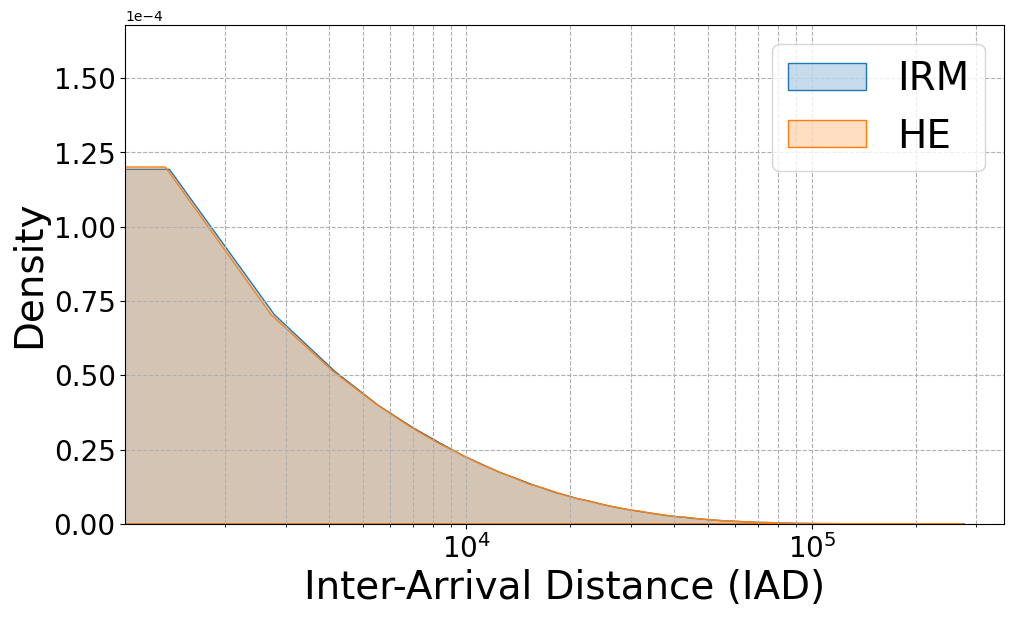

In [22]:
# iads should match
iads2 = tg.iad(trace2)
plt.figure(figsize=(10,6))
sns.kdeplot(iads1, bw_adjust=0.5, label='IRM', fill=True)
sns.kdeplot(iads2, bw_adjust=0.5, label='HE', fill=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.tick_params(axis='both',  labelsize=20)
plt.tight_layout()
plt.xscale('log')
plt.xlabel('Inter-Arrival Distance (IAD)', fontsize=28)
plt.ylabel('Density', fontsize=28)
plt.legend(fontsize=28)
plt.grid(True, which="both", ls="--")
plt.show()

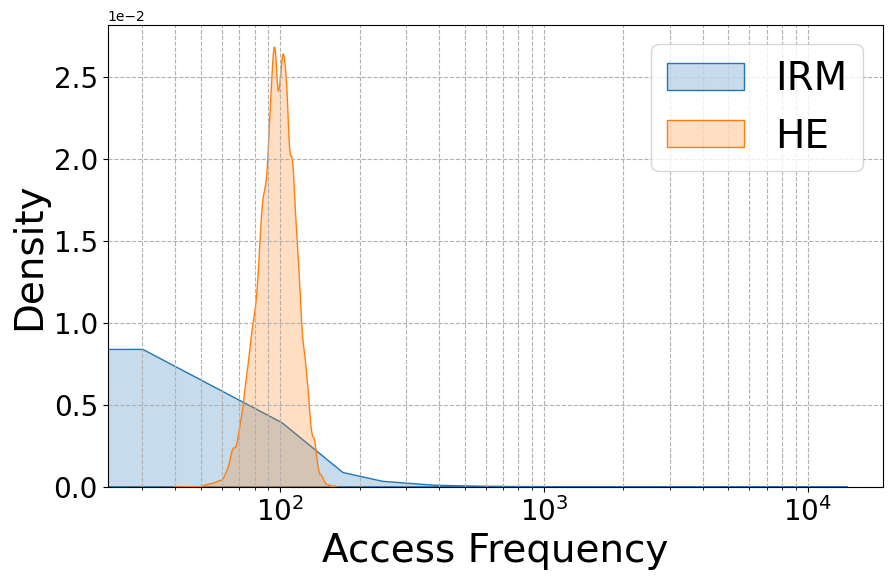

In [23]:
# frequency should not match
u1, c1 = np.unique(trace1, return_counts=True)
u2, c2 = np.unique(trace2, return_counts=True)
plt.figure(figsize=(10,6))
sns.kdeplot(c1, bw_adjust=0.5, label='IRM', fill=True)
sns.kdeplot(c2, bw_adjust=0.5, label='HE', fill=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.tick_params(axis='both',  labelsize=20)
plt.xscale('log')
plt.xlabel('Access Frequency', fontsize=28)
plt.ylabel('Density', fontsize=28)
plt.legend(fontsize=28)
plt.grid(True, which="both", ls="--")
plt.show()

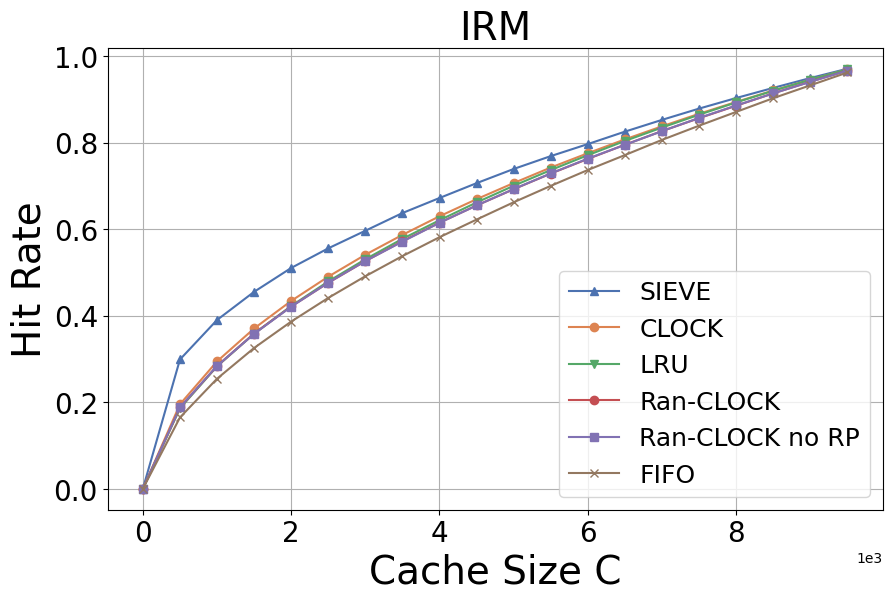

IRM Average Hit Rates:
SIEVE: 0.671609
CLOCK: 0.6338612499999999
LRU: 0.6279068000000001
Ran-CLOCK no RP: 0.62321205
Ran-CLOCK: 0.62319635
FIFO: 0.59947345


In [24]:
c, hr_ran_clock = sim_ran_clock_rp(trace1)
cn, hr_ran_clock_no_rp = sim_ran_clock_no_rp(trace1)
cc, hr_clock = sim_clock(trace1)
cs, hr_sieve = sim_sieve(trace1)
cl, hr_lru = sim_lru(trace1)
cf, hr_fifo = sim_fifo(trace1)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cs, hr_sieve, color=palette[0], marker='^', label='SIEVE')
plt.plot(cc, hr_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl, hr_lru, color=palette[2], marker='v', label='LRU')
plt.plot(c, hr_ran_clock, color=palette[3], marker='o', label='Ran-CLOCK')
plt.plot(cn, hr_ran_clock_no_rp, color=palette[4], marker='s', label='Ran-CLOCK no RP')
plt.plot(cf, hr_fifo, color=palette[5], marker='x', label='FIFO')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('IRM', fontsize=28)
plt.grid(True)
plt.show()

avgs = [('SIEVE', np.mean(np.array(hr_sieve))),
        ('CLOCK', np.mean(np.array(hr_clock))),
        ('LRU', np.mean(np.array(hr_lru))),
        ('Ran-CLOCK', np.mean(np.array(hr_ran_clock))),
        ('Ran-CLOCK no RP', np.mean(np.array(hr_ran_clock_no_rp))),
        ('FIFO', np.mean(np.array(hr_fifo)))]
avgs.sort(key=lambda x: x[1], reverse=True)
print("IRM Average Hit Rates:")
for name, avg in avgs:
    print(f"{name}: {avg}")

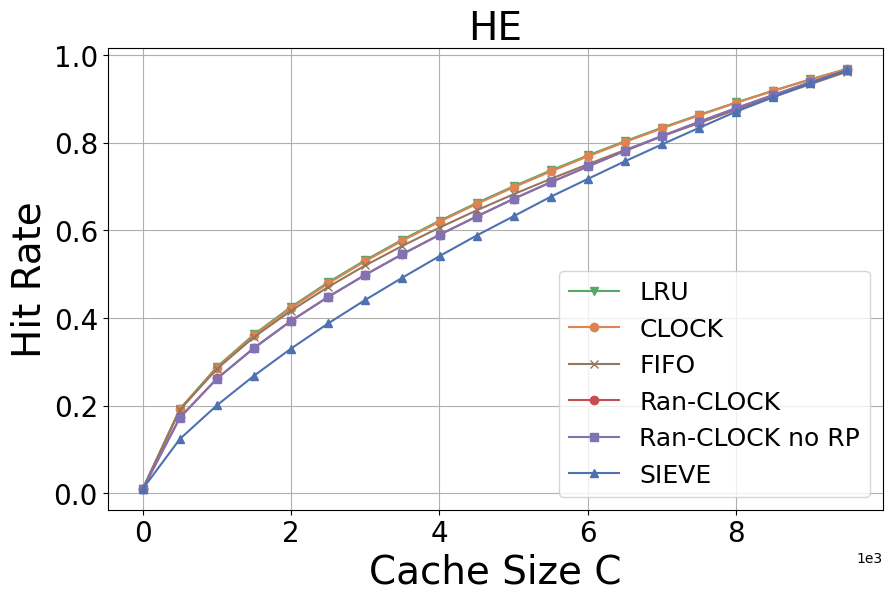

HE Average Hit Rates:
LRU: 0.62963145
CLOCK: 0.62793385
FIFO: 0.616907
Ran-CLOCK no RP: 0.60746795
Ran-CLOCK: 0.60741575
SIEVE: 0.5738447499999999


In [25]:
c2, hr_ran_clock2 = sim_ran_clock_rp(trace2)
cn2, hr_ran_clock_no_rp2 = sim_ran_clock_no_rp(trace2)
cc2, hr_clock2 = sim_clock(trace2)
cs2, hr_sieve2 = sim_sieve(trace2)
cl2, hr_lru2 = sim_lru(trace2)
cf2, hr_fifo2 = sim_fifo(trace2)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cl2, hr_lru2, color=palette[2], marker='v', label='LRU')
plt.plot(cc2, hr_clock2, color=palette[1], marker='o', label='CLOCK')
plt.plot(cf2, hr_fifo2, color=palette[5], marker='x', label='FIFO')
plt.plot(c2, hr_ran_clock2, color=palette[3], marker='o', label='Ran-CLOCK')
plt.plot(cn2, hr_ran_clock_no_rp2, color=palette[4], marker='s', label='Ran-CLOCK no RP')
plt.plot(cs2, hr_sieve2, color=palette[0], marker='^', label='SIEVE')

plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('HE', fontsize=28)
plt.grid(True)
plt.show()

avgs2 = [('SIEVE', np.mean(np.array(hr_sieve2))),
         ('CLOCK', np.mean(np.array(hr_clock2))),
         ('LRU', np.mean(np.array(hr_lru2))),
         ('Ran-CLOCK', np.mean(np.array(hr_ran_clock2))),
         ('Ran-CLOCK no RP', np.mean(np.array(hr_ran_clock_no_rp2))),
         ('FIFO', np.mean(np.array(hr_fifo2)))]
avgs2.sort(key=lambda x: x[1], reverse=True)
print("HE Average Hit Rates:")
for name, avg in avgs2:
    print(f"{name}: {avg}")

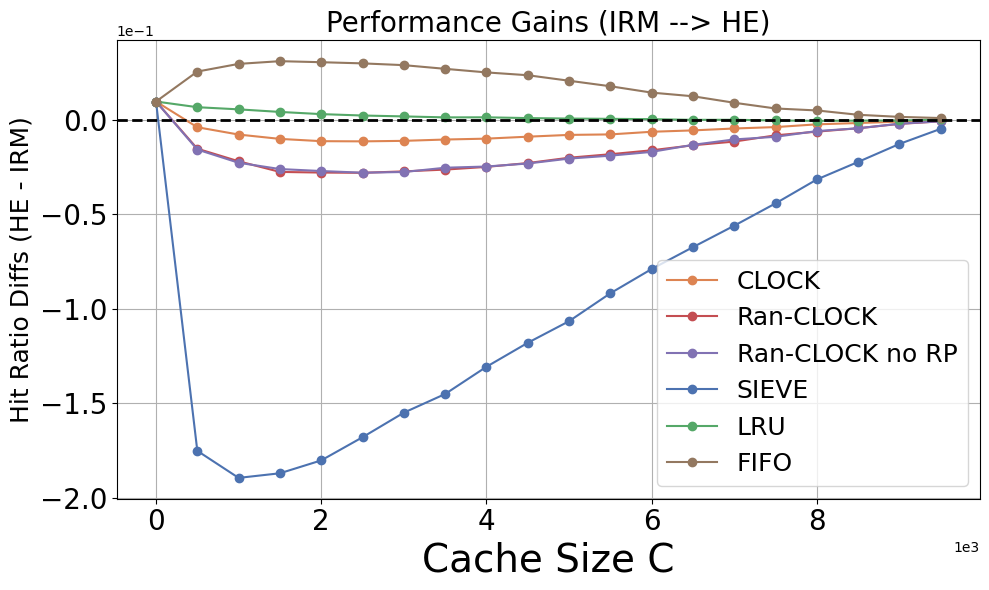

In [26]:

policies = ["CLOCK", "Ran-CLOCK", "Ran-CLOCK no RP", "SIEVE", "LRU", "FIFO"]
irm_hr = [hr_clock, hr_ran_clock, hr_ran_clock_no_rp,hr_sieve, hr_lru, hr_fifo]
he_hr  = [hr_clock2, hr_ran_clock2,  hr_ran_clock_no_rp2,hr_sieve2, hr_lru2, hr_fifo2]
colors = [palette[1], palette[3], palette[4], palette[0], palette[2], palette[5]]

rows = []
for name, irm, he in zip(policies, irm_hr, he_hr):
    irm = np.array(irm)
    he  = np.array(he)
    delta = he - irm
    for C, d in zip(c, delta):
        rows.append({"C": C, "policy": name, "delta_hr": d})

df_delta = pd.DataFrame(rows)
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
for name, color in zip(policies, colors):
    sub = df_delta[df_delta["policy"] == name]
    plt.plot(sub["C"], sub["delta_hr"], marker='o', label=name, color=color)
plt.axhline(0, color='black', linewidth=2, linestyle='--')
plt.xlabel("Cache Size C", fontsize=28)
plt.ylabel("Hit Ratio Diffs (HE - IRM)", fontsize=18)
plt.title("Performance Gains (IRM --> HE)", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Data: 
# n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit.
sieve = tg.sieve(4000)
sieve.run(trace1)
rclock = tg.ran_clock(4000)
rclock.run(trace1, rp=True)
rclock2 = tg.ran_clock(4000)
rclock2.run(trace1, rp=False)
clock = tg.clock(4000)
clock.run(trace1)
from trace_gen.lru_wrapper import lru as LRU 
lru = LRU(4000)
lru.run(trace1)
fifo = tg.fifo(4000)
fifo.run(trace1)

print("IRM Data at C=4000")
print("n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit")
print(f"sieve: {sieve.data()}")
print(f"ran-clock: {rclock.data()}")
print(f"ran-clock no rp: {rclock2.data()}")
print(f"clock: {clock.data()}")
print(f"lru: {lru.data()}")
print(f"fifo: {fifo.data()}")

IRM Data at C=4000)
n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit
sieve: (1000000, 328067, 7172, 63932, 387999, 63932)
ran-clock: (1000000, 385560, 7172, 233818, 615378, 610598)
ran-clock no rp: (1000000, 384870, 7172, 233638, 614508, 611280)
clock: (1000000, 370285, 7172, 296881, 663166, 627620)
lru: (1000000, 379449, 7172)
fifo: (1000000, 418578, 7172)


In [31]:
sieve = tg.sieve(4000)
sieve.run(trace2)
rclock = tg.ran_clock(4000)
rclock.run(trace2, rp=True)
rclock2 = tg.ran_clock(4000)
rclock2.run(trace2, rp=False)
clock = tg.clock(4000)
clock.run(trace2)
from trace_gen.lru_wrapper import lru as LRU 
lru = LRU(4000)
lru.run(trace2)
fifo = tg.fifo(4000)
fifo.run(trace2)

print("HE Data at C=4000")
print("n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit")
print(f"sieve: {sieve.data()}")
print(f"ran-clock: {rclock.data()}")
print(f"ran-clock no rp: {rclock2.data()}")
print(f"clock: {clock.data()}")
print(f"lru: {lru.data()}")
print(f"fifo: {fifo.data()}")

HE Data at C=4000
n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit
sieve: (1000000, 458816, 5667, 278706, 733522, 278706)
ran-clock: (1000000, 410007, 5667, 303293, 709300, 586639)
ran-clock no rp: (1000000, 409895, 5667, 303133, 709028, 586736)
clock: (1000000, 380380, 5667, 361949, 738329, 617776)
lru: (1000000, 378221, 5667)
fifo: (1000000, 393623, 5667)


# Summary
- Under IRM workloads, SIEVE outperforms all other caches; but under HE workloads with the same IAD distribution its performance degrades significantly;
- All caches require 7172 (5667) accesses to fill a capacity-4000 cache under IRM (HE).